In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# BI/RETURN CORRELATION

In [2]:
import os


def read_orderbook_df(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, sep='\t')
    df['MidPrice'] = (df["AskPrice1"]+df["BidPrice1"])/2
    df['Return'] = (-df["MidPrice"]+df["MidPrice"].shift(-1)) / df["MidPrice"]

    pbid = df["BidPrice1"] - df[f"BidPrice15"]
    pask = df[f"AskPrice15"] - df["AskPrice1"]
    df["BaseImbalance"] = (pbid-pask)/(pbid+pask)

    df=df.dropna(subset=['Return', 'BaseImbalance'])
    df = df[df['Return'] != 0]
    df = df[['Timestamp', 'BaseImbalance', 'Return']]
    df['Diff'] = df['Timestamp'].diff()

    return df

def read_best_densities_df(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path)

def get_subsetted_orderbook_df(orderbook_df: pd.DataFrame, simulation_time_seconds: int) -> pd.DataFrame:
    simulation_time_milliseconds = simulation_time_seconds * 1000
    training_start_time = simulation_time_milliseconds - (1800*1000)
    simulation_end_time = simulation_time_milliseconds + (120*1000)
    return orderbook_df[
        (orderbook_df['Timestamp'] >= training_start_time)
        & (orderbook_df['Timestamp'] <= simulation_end_time)
    ]

def get_all_df(best_densities_df: pd.DataFrame, orderbook_dir_path: str) -> pd.DataFrame:
    dfs = []
    for i in range(len(best_densities_df)):
        timestamp_filename = str(best_densities_df.iloc[i]['timestamp'])
        simulation_time_seconds = best_densities_df.iloc[i]['timestamp_density']
        
        orderbook_filename = [f for f in os.listdir(orderbook_dir_path)
                              if timestamp_filename in f][0]
        
        orderbook_df = read_orderbook_df(
            os.path.join(orderbook_dir_path,orderbook_filename))
        subsetted_orderbook_df = get_subsetted_orderbook_df(orderbook_df, simulation_time_seconds)
        dfs.append(subsetted_orderbook_df)

    return pd.concat(dfs)

def get_decile_mean_df(metrics_df: pd.DataFrame) -> pd.DataFrame:
    metrics_df['decile'] = pd.qcut(metrics_df['BaseImbalance'], q=10, labels=False, precision=0)
    average_values = metrics_df.groupby('decile')[['BaseImbalance', 'Return']].mean()
    return average_values


In [7]:
pair = 'BTC_USDT'
best_density_df = read_best_densities_df(f'data_{pair}/best_densities_full.csv')
orderbook_df = get_all_df(best_density_df, f'/home/davide/Desktop/phd/bitfinex-api-py/data/{pair}/orderbook_changes')
orderbook_df['Diff'] = (orderbook_df['Diff']).abs() / 1000

orderbook_df.head()

,Timestamp,BaseImbalance,Return,Diff
22611,1711631859297,0.138462,-0.000092,0.372
22612,1711631859503,0.111111,0.000007,0.206
22614,1711631859704,0.062500,-0.000014,0.201
22615,1711631860006,0.127273,0.000057,0.302
22619,1711631860899,0.233333,-0.000028,0.893


In [8]:
orderbook_df[['BaseImbalance', 'Return']].corr()

,BaseImbalance,Return
BaseImbalance,1.000000,-0.230592
Return,-0.230592,1.000000


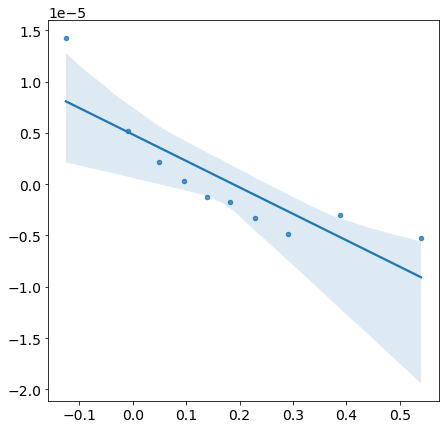

In [20]:
decile_df = get_decile_mean_df(orderbook_df)
# Select two columns for the scatterplot
x_column = 'BaseImbalance'
y_column = 'Return'

# increase plot size
plt.figure(figsize=(7, 7))
# increase labels size
plt.rcParams.update({'font.size': 14})

# Create a scatterplot with regression line using Seaborn
sns.regplot(data=decile_df, x=x_column, y=y_column, scatter_kws={'s': 20})
#plt.title(f'Divided in deciles using Returns')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [19]:
decile_df.corr()

,BaseImbalance,Return
BaseImbalance,1.000000,-0.855437
Return,-0.855437,1.000000


In [10]:
usdt_df = pd.read_csv('/home/davide/Desktop/phd/BITFINEX_SPOT_USDT_USD.csv', sep=';')
usdt_df['MidPrice'] = (usdt_df["asks[0].price"]+usdt_df["bids[0].price"])/2
usdt_df['Return'] = (-usdt_df["MidPrice"]+usdt_df["MidPrice"].shift(-1)) / usdt_df["MidPrice"]
usdt_df = usdt_df[usdt_df['Return'] != 0]
usdt_df['time_exchange'] = pd.to_datetime(usdt_df['time_exchange'], format='%H:%M:%S.%f')

# Calculate total milliseconds and create 'Timestamp' column
usdt_df['Timestamp'] = usdt_df['time_exchange'].dt.hour * 3600000 + usdt_df['time_exchange'].dt.minute * 60000 + usdt_df['time_exchange'].dt.second * 1000 + usdt_df['time_exchange'].dt.microsecond / 1000
usdt_df['Diff'] = usdt_df['Timestamp'].diff()
usdt_df['Diff'] = (usdt_df['Diff']).abs() / 1000

usdt_df.head()

,time_exchange,time_coinapi,asks[0].price,asks[0].size,bids[0].price,bids[0].size,asks[1].price,asks[1].size,bids[1].price,bids[1].size,...,bids[48].price,bids[48].size,asks[49].price,asks[49].size,bids[49].price,bids[49].size,MidPrice,Return,Timestamp,Diff
3,1900-01-01 00:00:14.366688200,00:00:14.3666882,1.012,23982.982590,1.0118,39508.944704,1.0123,10.35267,1.0115,5817.791828,...,1.0033,2491.421600,1.0338,110.00,1.0032,23648.286768,1.01190,0.000049,14366.688,NaN
139,1900-01-01 00:04:04.848756100,00:04:04.8487561,1.012,13476.768275,1.0119,10000.000000,1.0123,10.35267,1.0118,39508.944704,...,1.0037,2425.452057,1.0360,50000.00,1.0036,1602.059566,1.01195,-0.000049,244848.756,230.482068
156,1900-01-01 00:04:35.223321800,00:04:35.2233218,1.012,13476.768275,1.0118,39508.944704,1.0123,10.35267,1.0116,4000.000000,...,1.0037,2425.452057,1.0350,119.76,1.0036,1602.059566,1.01190,0.000049,275223.321,30.374565
159,1900-01-01 00:04:42.317190300,00:04:42.3171903,1.012,13476.768275,1.0119,11323.162713,1.0123,10.35267,1.0118,39508.944704,...,1.0037,2425.452057,1.0360,50000.00,1.0036,1602.059566,1.01195,-0.000049,282317.190,7.093869
160,1900-01-01 00:04:43.338182100,00:04:43.3381821,1.012,13476.768275,1.0118,39508.944704,1.0123,10.35267,1.0116,4000.000000,...,1.0036,1602.059566,1.0360,50000.00,1.0035,30020.020020,1.01190,0.000049,283338.182,1.020992


Text(0, 0.5, 'Event duration [s]')

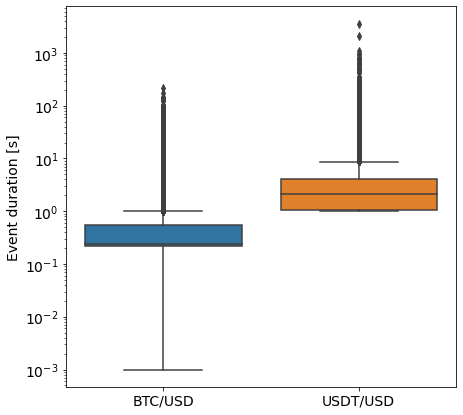

In [11]:

btc_df_diff = orderbook_df[['Diff']].copy()
btc_df_diff['Pair'] = 'BTC/USD'
usdt_df_diff = usdt_df[['Diff']].copy()
usdt_df_diff['Pair'] = 'USDT/USD'

diff_df = pd.concat([btc_df_diff, usdt_df_diff])


# boxplot of the differences with log scale

plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 14})
sns.boxplot(data=diff_df, x='Pair', y='Diff')
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Event duration [s]')

# Orderbook Barplot

In [12]:
orderbook_df = pd.read_csv('/home/davide/Desktop/phd/bitfinex-api-py/data/orderbook_changes/orderbook_changes_1705074061033.tsv', sep='\t')
# Put Timestamp column as the first
orderbook_df = orderbook_df[['Timestamp'] + [col for col in orderbook_df.columns if col != 'Timestamp']]
orderbook_df.head()


,Timestamp,AskPrice1,AskSize1,AskPrice2,AskSize2,AskPrice3,AskSize3,AskPrice4,AskSize4,AskPrice5,...,BidPrice21,BidSize21,BidPrice22,BidSize22,BidPrice23,BidSize23,BidPrice24,BidSize24,BidPrice25,BidSize25
0,1705070760834,45301,3.169369,45304,0.113010,45309,0.01100,45310,0.01100,45312,...,45259.0,0.088360,45258.0,0.110470,45257.0,0.061664,45256.0,0.052545,45255.0,0.126800
1,1705070761067,45301,3.119589,45304,0.113010,45309,0.01100,45310,0.01100,45312,...,45258.0,0.163015,45257.0,0.140482,45256.0,0.105091,45255.0,0.126800,45254.0,0.291057
2,1705070761299,45301,3.119589,45302,0.002650,45303,0.16962,45304,0.11036,45306,...,45257.0,0.061664,45255.0,0.126800,45254.0,0.212239,45252.0,0.078818,45251.0,0.105091
3,1705070761526,45301,3.548009,45302,0.016771,45304,0.11036,45306,0.75000,45309,...,45257.0,0.061664,45255.0,0.126800,45254.0,0.159694,45252.0,0.052545,45251.0,0.078818
4,1705070761753,45301,3.550659,45302,0.764121,45304,0.11036,45309,0.01100,45310,...,45257.0,0.061664,45255.0,0.126800,45254.0,0.159694,45250.0,0.057605,45249.0,0.078818


In [13]:
row_df = pd.DataFrame(orderbook_df.iloc[0]).reset_index()
row_df = row_df[row_df['index'] != 'Timestamp']
row_df['side'] = row_df['index'].str[0:3]
row_df['type'] = row_df['index'].str.extract(r'(Price|Size)')
row_df.drop('index', axis=1, inplace=True)
row_df.columns = ['Value', 'Side', 'Type']
row_df.head()

,Value,Side,Type
1,45301.000000,Ask,Price
2,3.169369,Ask,Size
3,45304.000000,Ask,Price
4,0.113010,Ask,Size
5,45309.000000,Ask,Price


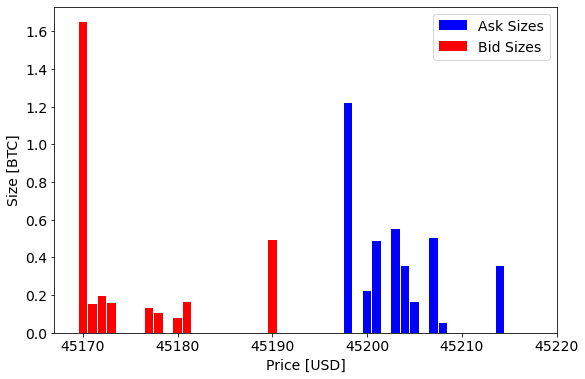

In [14]:
# Extract values for the first row
row = orderbook_df.iloc[10000]

# Increase plot size
plt.figure(figsize=(9, 6))
# Increase labels size
plt.rcParams.update({'font.size': 14})

# Extract prices and sizes
ask_prices = [row[f'AskPrice{i}'] for i in range(1, 10)]
ask_sizes = [row[f'AskSize{i}'] for i in range(1, 10)]
bid_prices = [row[f'BidPrice{i}'] for i in range(1, 10)]
bid_sizes = [row[f'BidSize{i}'] for i in range(1, 10)]

# Plot the data
plt.bar(ask_prices, ask_sizes, width=0.9, color='blue', label='Ask Sizes')
plt.bar(bid_prices, bid_sizes, width=0.9, color='red', label='Bid Sizes')
plt.xlabel('Price [USD]')
plt.ylabel('Size [BTC]')
plt.xlim(45167, 45220)
plt.legend()
plt.show()


# PROFIT LINEPLOT

In [20]:
from typing import List


coe_df = pd.read_csv('data_right/poisson_5/1705356920082_1705356579_BI15.csv')
train_coe = coe_df[coe_df['Timestamp'] < 1800].copy()
test_coe = coe_df[coe_df['Timestamp'] >= 1800].copy()
test_coe['TestTimestamp'] = range(0,120)

def _get_index_positions_without_old_greater_predictions(
    series: pd.Series,
) -> pd.Series:
    to_delete_index_positions = []
    for i in range(0, len(series)):
        for j in range(i + 1, len(series)):
            if series.iloc[i] > series.iloc[j]:
                to_delete_index_positions.append(i)
                break

    return to_delete_index_positions


def _get_dataframe_without_index_positions(
    df: pd.DataFrame, index_positions: List
) -> pd.DataFrame:
    return df.drop(df.index[index_positions])


def get_dataframe_without_old_greater_predictions(
    df: pd.DataFrame, column_name: str
) -> pd.DataFrame:
    series = df[column_name]
    to_delete_index_positions = _get_index_positions_without_old_greater_predictions(
        series
    )
    df = _get_dataframe_without_index_positions(df, to_delete_index_positions)

    return df

test_coe = get_dataframe_without_old_greater_predictions(test_coe, 'Timestamp')

coe_df = pd.concat([train_coe, test_coe])
coe_df.to_csv('data_right/poisson.csv', index=False)

test_coe.head()

,Timestamp,BaseImbalance,Return,LastEventTimestampNotScaled,NearestEventTimestampNotScaled,RealNextEventTimestampNotScaled,TestTimestamp
1580,1800.887,0.063830,-0.000012,1796.923,1801.288,1800.318,0
1581,1802.205,-0.137931,0.000012,1800.318,1802.414,1801.288,1
1582,1803.866,0.081081,0.000047,1801.979,1804.406,1802.414,2
1583,1804.774,-0.142857,-0.000035,1802.887,1804.654,1803.100,3
1584,1805.204,0.069767,0.000012,1803.317,1805.387,1804.406,4


In [31]:
dfs = list()
for filesuffix in ['hawkes', 'movingaverage', 'naive', 'oracle', 'poisson']:
    oracle_profit_df = pd.read_csv(f'data_right/profits_{filesuffix}.tsv', sep='\t')
    oracle_profit_df['profit'] = oracle_profit_df['profit'] * 1e4
    oracle_profit_df['profit'] = oracle_profit_df[['profit', 'is_pred_right']].apply(lambda x: abs(x[0]) if x[1] == 1 else -abs(x[0]), axis=1)
    oracle_profit_df['profit'] = oracle_profit_df['profit'].cumsum()
    oracle_profit_df['timestamp'] = oracle_profit_df['timestamp'] - 1800
    oracle_profit_df.drop('is_pred_right', axis=1, inplace=True)
    dfs.append(oracle_profit_df)

profit_df = pd.concat(dfs)
profit_df.head()

,timestamp,profit,method
0,3.790,-0.351589,hawkes
1,4.019,-0.820390,hawkes
2,5.737,-0.703194,hawkes
3,6.628,-0.585999,hawkes
4,11.500,-0.234435,hawkes


In [32]:
hawkes = profit_df[profit_df['method'] == 'hawkes']
oracle = profit_df[profit_df['method'] == 'oracle']
movingaverage = profit_df[profit_df['method'] == 'movingaverage']
naive = profit_df[profit_df['method'] == 'naive']
poisson = profit_df[profit_df['method'] == 'poisson']

hawkes = hawkes.append({'timestamp': 0, 'profit': 0, 'method': 'hawkes'}, ignore_index=True)
movingaverage = movingaverage.append({'timestamp': 0, 'profit': 0, 'method': 'movingaverage'}, ignore_index=True)
oracle = oracle.append({'timestamp': 0, 'profit': 0, 'method': 'oracle'}, ignore_index=True)
naive = naive.append({'timestamp': 0, 'profit': 0, 'method': 'naive'}, ignore_index=True)
poisson = poisson.append({'timestamp': 0, 'profit': 0, 'method': 'poisson'}, ignore_index=True)

orderbook_df = pd.read_csv('/home/davide/Desktop/phd/bitfinex-api-py/data/orderbook_changes/orderbook_changes_1705356920082.tsv', sep='\t')
# Put Timestamp column as the first
orderbook_df = orderbook_df[['Timestamp'] + [col for col in orderbook_df.columns if col != 'Timestamp']]
orderbook_df = orderbook_df[orderbook_df['Timestamp'] >= 1705356579000]
orderbook_df = orderbook_df[orderbook_df['Timestamp'] <= 1705356579000 + 120000]
orderbook_df['OffsetTimestamp'] = (orderbook_df['Timestamp'] - 1705356579000) / 1000
orderbook_df['MidPrice'] = (orderbook_df["AskPrice1"]+orderbook_df["BidPrice1"])/2
orderbook_df.head()


,Timestamp,AskPrice1,AskSize1,AskPrice2,AskSize2,AskPrice3,AskSize3,AskPrice4,AskSize4,AskPrice5,...,BidPrice22,BidSize22,BidPrice23,BidSize23,BidPrice24,BidSize24,BidPrice25,BidSize25,OffsetTimestamp,MidPrice
35083,1705356579076,42655,0.00200,42668,0.05790,42672,0.05000,42673,0.098040,42675,...,42619.0,0.301216,42617.0,0.456875,42616.0,2.333742,42615.0,0.017291,0.076,42654.5
35084,1705356579317,42655,0.00200,42672,0.05000,42673,0.09804,42675,0.355810,42676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.317,42654.5
35085,1705356579318,42655,0.00200,42667,0.07026,42670,0.09138,42672,0.050000,42673,...,42618.0,0.481396,42616.0,2.333742,42615.0,0.134122,42614.0,1.260612,0.318,42654.5
35086,1705356579539,42667,0.25946,42671,0.74790,42672,0.09070,42673,0.302810,42674,...,42623.0,0.051000,42622.0,0.001337,42620.0,0.180180,42618.0,0.301216,0.539,42660.5
35087,1705356579801,42667,0.25946,42672,0.09070,42673,0.30281,42676,0.094073,42682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.801,42660.5


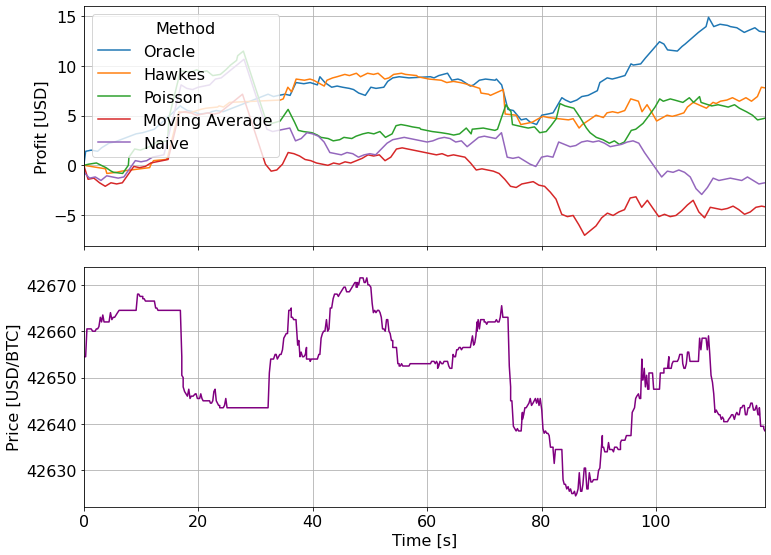

In [35]:
# produce a lineplot of the profits where x is the timestamp and y is the profit and the hue is the method
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, 1, figsize=(11, 8))# put a grid on the plot
plt.grid(True)
sns.lineplot(data=oracle, x='timestamp', y='profit', label='Oracle', ax=axs[0])
sns.lineplot(data=hawkes, x='timestamp', y='profit', label='Hawkes', ax=axs[0])
sns.lineplot(data=poisson, x='timestamp', y='profit', label='Poisson', ax=axs[0])
sns.lineplot(data=movingaverage, x='timestamp', y='profit', label='Moving Average', ax=axs[0])
sns.lineplot(data=naive, x='timestamp', y='profit', label='Naive', ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_xlim(0, 119)
axs[0].set_ylabel('Profit [USD]')
axs[0].grid(True)
axs[0].set_xticklabels([])  # Remove x-axis tick labels

axs[0].legend(loc='upper left', title='Method')
# put a grid on the plot
axs[1].grid(True)
sns.lineplot(data=orderbook_df, x='OffsetTimestamp', y='MidPrice', color='purple', ax=axs[1])
axs[1].set_xlim(0, 119)
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Price [USD/BTC]')

plt.tight_layout()
plt.show()

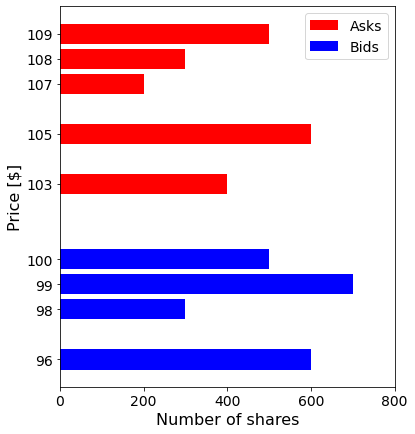

In [1]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 7))
# Increase labels size
plt.rcParams.update({'font.size': 14})


buy_orders = {'Price': [100, 99, 98, 96], 'Quantity': [500, 700, 300, 600]}
sell_orders = {'Price': [103, 105, 107, 108, 109], 'Quantity': [400, 600, 200, 300, 500]}

# Extract unique price levels from both buy and sell orders
unique_prices = sorted(set(buy_orders['Price'] + sell_orders['Price']))

# Plotting sell orders first
plt.barh(sell_orders['Price'], sell_orders['Quantity'], color='red', label='Asks')

# Plotting buy orders after
plt.barh(buy_orders['Price'], buy_orders['Quantity'], color='blue', label='Bids')

plt.xlim(0, 800)
# Set y ticks labels only at unique price levels
plt.yticks(unique_prices)
# Set labels and title
plt.xlabel('Number of shares', fontsize=16)
plt.ylabel('Price [$]', fontsize=16)
plt.legend(loc='upper right')
# Display plot
plt.show()